In [1]:
import sys
import os

# Adjust this path to point to the root of your project (the one containing `src/`)
project_root = os.path.abspath("..")  # or "../../" depending on where notebook is
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import numpy as np
from src.lvmogp.lvmogp_ssvi import LVMOGP_SSVI_Torch
import pathlib as pl
import os
from src.lvmogp.lvmogp_test_functions import TestFun

2025-06-27 22:29:59.495021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751063399.513175    2508 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751063399.518732    2508 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751063399.532646    2508 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751063399.532667    2508 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751063399.532670    2508 computation_placer.cc:177] computation placer alr

In [3]:
import torch
from src.lvmogp.lvmogp_ssvi import LVMOGP_SSVI_Torch      
from src.gp_dataclasses  import GPSSVIConfig
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

# Quick Notebook Showing how to fit the LVMOGP

In [4]:
seed=1
surface_type = 'linear_relation'
n_new_points=20
n_new_funs = 10
data_type_name = f'two_observed_{n_new_funs}_new'
n_fun = 2 + n_new_funs
total_train = 30*2 + 3 * n_new_points
n_points = [10]*2 + [n_new_points]*n_new_funs
n_train = n_points

set_opt_seed = False

same_points = False
plot_figs = True

train_inducing = True
domain = [0, 2]
latent_dims = 2
latent_dims_lvmogp = 2
observed_dims = 1
max_points = 60

noise = 0.05
n_grid_points = 100
continuous_dims = ['x1', 'x2'][:observed_dims]
lengthscales_x = [0.3, 0.3]
lengthscales_h = [0.4, 0.4, 0.4, 0.4, 0.4, 0.4][:latent_dims]


test_fun = TestFun(domain=domain, seed=seed, n_fun=n_fun,
                   observed_dims=observed_dims, test_type=surface_type, latent_dims=latent_dims, max_points=max_points,
                   noise=noise, n_grid_points=n_grid_points, same_points=same_points, lengthscales_X=lengthscales_x,
                   lengthscales_H=lengthscales_h)

W0000 00:00:1751063403.423725    2508 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Generate and Plot the Data

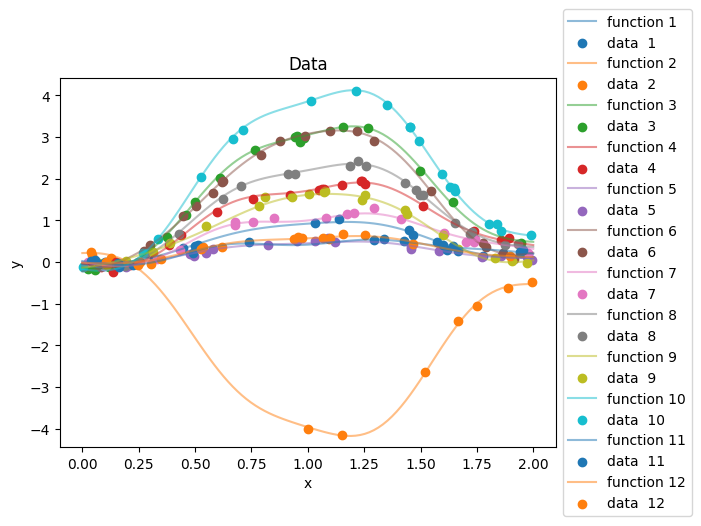

In [5]:
data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)


if plot_figs:
    test_fun.plot_data(n_points)

## Fit the LVMOGP

Randomly initialise the hyperparameters

In [6]:
torch.set_default_dtype(torch.float64)

# random H initialisation (unchanged values, just Torch)
H_mean = torch.tensor(
    np.random.uniform(-1, 1, (n_fun, latent_dims_lvmogp)),
    dtype=torch.float64
)
H_var  = torch.full_like(H_mean, 1e-6)

# likelihood noise (same formula as before)
lik_variance = np.var(data_y) * 0.01
n_u          =  70                     # number of inducing inputs

Make the LVMOGP

In [7]:
Y_torch  = torch.tensor(data_y , dtype=torch.float64)
X_torch  = torch.tensor(data_X , dtype=torch.float64)
fn_torch = torch.tensor(fun_nos, dtype=torch.float64)

# H_mean = (n_fun, Q)
H_mean_all = torch.tensor(H_mean[fun_nos.flatten()], dtype=torch.float64)  # shape (N, Q)
H_var_all  = torch.full_like(H_mean_all, 1e-6)

model = LVMOGP_SSVI_Torch(
    data        = Y_torch,
    X_data      = X_torch,
    X_data_fn   = fn_torch,
    H_data_mean = H_mean_all,
    H_data_var  = H_var_all,
    num_inducing_variables = n_u,
)


/tmp/ipykernel_2508/4154977831.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_mean_all = torch.tensor(H_mean[fun_nos.flatten()], dtype=torch.float64)  # shape (N, Q)


In [8]:
from src.gp_dataclasses import (
    GPSSVIConfig,
    LR,
    Rho,
    Training,
    InnerIters,
    InducingConfig,
    InitXDistSsvi,
)


cfg = GPSSVIConfig(
    device="cuda",                    
    debug=False,
    jitter=5e-6,
    max_exp=60.0,
    q_latent=latent_dims_lvmogp,
    init_signal_to_noise_ratio=30.0,
    num_u_samples_per_iter=2,

    lr=LR(
        x=1e-3,
        hyp=3e-3,
        alpha=5e-3,
    ),

    rho=Rho(
        t0=100.0,
        k=0.6,
    ),

    training=Training(
        batch_size=min(128, len(data_X)),
        total_iters=200,
        inner_iters=InnerIters(
            start=50,
            after=40,
            switch=50,
        ),
    ),

    inducing=InducingConfig(
        n_inducing=n_u,
        selection="perm",
        seed=19,
    ),

    init_latent_dist=InitXDistSsvi(
        method="default",
        custom_path=None,
    ),
)


Train it

In [9]:
print(cfg)
results = model.ssvi_train(cfg)          # trains in Torch

GPSSVIConfig(device='cuda', debug=False, jitter=5e-06, max_exp=60.0, q_latent=2, init_signal_to_noise_ratio=30.0, num_u_samples_per_iter=2, lr=LR(x=0.001, hyp=0.003, alpha=0.005), rho=Rho(t0=100.0, k=0.6), training=Training(batch_size=128, total_iters=200, inner_iters=InnerIters(start=50, after=40, switch=50)), inducing=InducingConfig(n_inducing=70, selection='perm', seed=19), init_latent_dist=InitXDistSsvi(method='default', custom_path=None))
Config auto selected device: cuda
num_u_samples_per_iter: 2
Data: N=220, D=1, D_x=1, Q=2, num_fns=12
snr: 30.0


  0%|▎                                                              | 1/200 [00:01<04:10,  1.26s/it]


DATASET FULL ELBO @   1: -4.8543e+03  LL=-2.3827e+03  KL_H=2.0099e+03  KL_U=4.6175e+02


 12%|███████▊                                                      | 25/200 [00:25<02:56,  1.01s/it]


DATASET FULL ELBO @  25: -2.7829e+03  LL=-8.4740e+02  KL_H=1.7775e+03  KL_U=1.5798e+02


 25%|███████████████▌                                              | 50/200 [00:50<02:31,  1.01s/it]


BATCH FULL ELBO @  50: -1.6056e+03  LL=-5.9087e+02  KL_H=8.8244e+02  KL_U=1.3230e+02
    sf2=1.188e+00, noise=4.705e-02, ratio=0.040
    log_sf2=0.172, log_beta_inv=-3.056, log_alpha min/max=-1.955/-1.750
    grad_norm_H   =2.93e+02, grad_norm_hyp =1.16e+04, grad_norm_alpha=3.38e+02
    step_norm_H   =2.37e+00, step_norm_hyp =2.51e-01, step_norm_alpha=1.71e-01
    Z_distances min=4.14e-03, max=2.29e+00

DATASET FULL ELBO @  50: -2.0514e+03  LL=-4.0429e+02  KL_H=1.5124e+03  KL_U=1.3470e+02


 38%|███████████████████████▎                                      | 75/200 [01:10<01:41,  1.23it/s]


DATASET FULL ELBO @  75: -1.6148e+03  LL=-2.1007e+02  KL_H=1.2742e+03  KL_U=1.3049e+02


 50%|██████████████████████████████▌                              | 100/200 [01:31<01:21,  1.22it/s]


BATCH FULL ELBO @ 100: -8.8853e+02  LL=-1.8716e+02  KL_H=6.0967e+02  KL_U=9.1696e+01
    sf2=1.151e+00, noise=4.868e-02, ratio=0.042
    log_sf2=0.140, log_beta_inv=-3.023, log_alpha min/max=-1.719/-1.532
    grad_norm_H   =8.90e+01, grad_norm_hyp =9.80e+03, grad_norm_alpha=2.15e+02
    step_norm_H   =2.62e+00, step_norm_hyp =5.40e-02, step_norm_alpha=3.88e-01
    Z_distances min=3.14e-03, max=2.29e+00

DATASET FULL ELBO @ 100: -1.2530e+03  LL=-1.4337e+02  KL_H=1.0213e+03  KL_U=8.8358e+01


 62%|██████████████████████████████████████▏                      | 125/200 [01:51<01:01,  1.23it/s]


DATASET FULL ELBO @ 125: -9.9499e+02  LL=-1.3811e+02  KL_H=7.7453e+02  KL_U=8.2351e+01


 75%|█████████████████████████████████████████████▊               | 150/200 [02:11<00:40,  1.22it/s]


BATCH FULL ELBO @ 150: -5.1700e+02  LL=-1.2868e+02  KL_H=3.1634e+02  KL_U=7.1981e+01
    sf2=1.145e+00, noise=4.900e-02, ratio=0.043
    log_sf2=0.135, log_beta_inv=-3.016, log_alpha min/max=-1.540/-1.317
    grad_norm_H   =8.16e+01, grad_norm_hyp =1.78e+03, grad_norm_alpha=1.55e+02
    step_norm_H   =9.21e-01, step_norm_hyp =3.51e-02, step_norm_alpha=3.68e-01
    Z_distances min=3.60e-03, max=2.29e+00

DATASET FULL ELBO @ 150: -7.4078e+02  LL=-1.1071e+02  KL_H=5.5756e+02  KL_U=7.2504e+01


 88%|█████████████████████████████████████████████████████▍       | 175/200 [02:31<00:20,  1.23it/s]


DATASET FULL ELBO @ 175: -5.3135e+02  LL=-1.0547e+02  KL_H=3.5778e+02  KL_U=6.8101e+01


100%|█████████████████████████████████████████████████████████████| 200/200 [02:52<00:00,  1.16it/s]


BATCH FULL ELBO @ 200: -2.6149e+02  LL=-8.3981e+01  KL_H=1.1327e+02  KL_U=6.4238e+01
    sf2=1.146e+00, noise=4.898e-02, ratio=0.043
    log_sf2=0.137, log_beta_inv=-3.016, log_alpha min/max=-1.367/-1.116
    grad_norm_H   =6.96e+01, grad_norm_hyp =4.56e+03, grad_norm_alpha=1.17e+02
    step_norm_H   =5.70e-01, step_norm_hyp =3.69e-02, step_norm_alpha=3.62e-01
    Z_distances min=3.78e-03, max=2.29e+00

DATASET FULL ELBO @ 200: -3.4806e+02  LL=-8.7262e+01  KL_H=1.9766e+02  KL_U=6.3143e+01


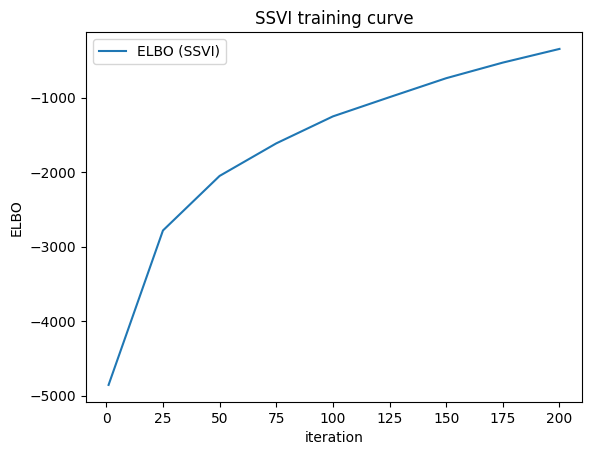

In [13]:
import matplotlib.pyplot as plt

iters = results["elbo_iters"]    # list saved by the trainer
elbo  = results["elbo_vals"]     # same as before

plt.plot(iters, elbo, label="ELBO (SSVI)")
plt.xlabel("iteration")
plt.ylabel("ELBO")
plt.title("SSVI training curve")
plt.legend()
plt.show()

Predict on new points

In [11]:
x_new = torch.linspace(domain[0], domain[1], 100,
                       dtype=torch.get_default_dtype(), device=model.DEV).view(-1, 1)   # (100,1)
xs_new = x_new.repeat(n_fun, 1)                                           # (100*n_fun, 1)

fun_ids = torch.unique(fn_torch, sorted=True)                      # (n_fun,)
X_data_fun_new = torch.cat([torch.full((len(x_new),), fid,
                                      dtype=torch.long, device=model.DEV)
                           for fid in fun_ids])                     # (100*n_fun,)

# Use format 1: (X_new, X_new_fn) - much cleaner!
lvm_mu, lvm_sig2 = model.predict_y((xs_new, X_data_fun_new))

Plot the predictions and the latent coordinates

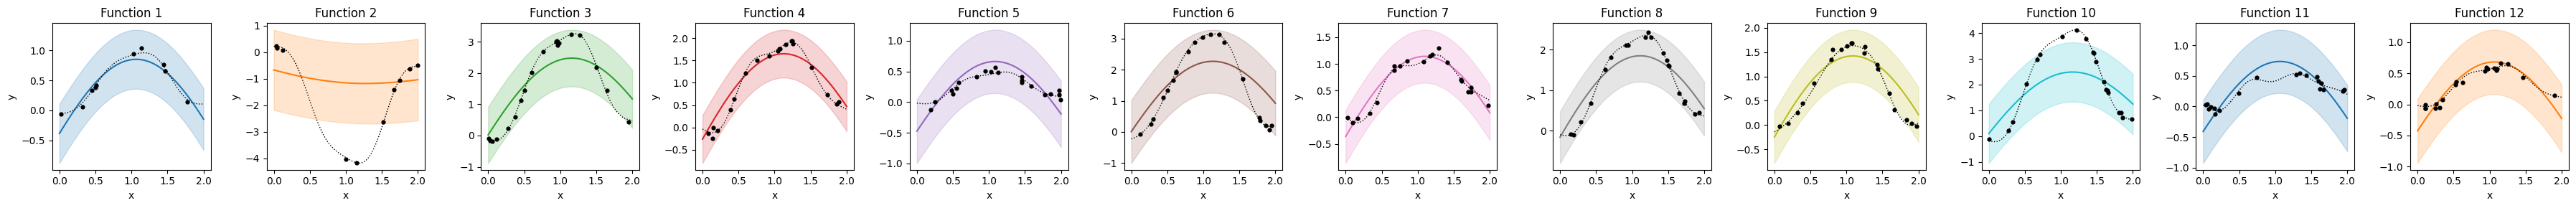

IndexError: list index out of range

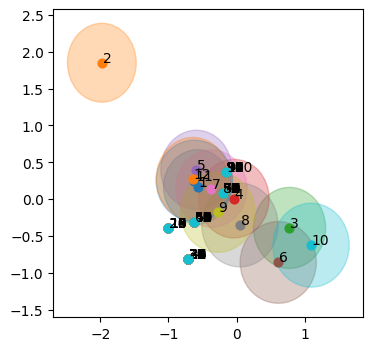

In [12]:
from matplotlib.patches import Ellipse
import numpy as np

# SETTINGS  
n_fun        = len(test_fun.functions)          # number of functions
pts_per_fun  = 100                              # x-points per function
palette      = (plt.rcParams['axes.prop_cycle']
                .by_key()['color']) * 10        # plenty of distinct colours

#  1. Ground-truth curves  
ys_new = []
for f in test_fun.functions:
    y_tf, _ = f.predict_y(x_new.cpu().numpy())              # GPflow → NumPy
    ys_new.append(torch.from_numpy(y_tf.numpy())            # NumPy → Torch
                       .to(dtype=x_new.dtype,
                           device=x_new.device))

#  2. LVMOGP predictions vs. ground-truth 
fig, axs = plt.subplots(1, ncols=n_fun, figsize=(3*n_fun, 3))
if n_fun == 1:
    axs = [axs]  # Make it iterable for single function case
else:
    axs = axs.flatten()

x_np   = x_new.cpu().numpy().flatten()                      # (100,)

lvm_mu_np = lvm_mu.cpu().numpy().squeeze()                  # (n_fun*100,)
lvm_sig2_np = lvm_sig2.cpu().numpy().squeeze()              # (n_fun*100,)

# Check if reshaping is valid
expected_size = n_fun * pts_per_fun
if lvm_mu_np.size != expected_size:
    print(f"Warning: Expected {expected_size} elements, got {lvm_mu_np.size}")
    pts_per_fun = lvm_mu_np.size // n_fun

mu_np = lvm_mu_np.reshape(n_fun, pts_per_fun)               # (n_fun, pts_per_fun)
s2_np = lvm_sig2_np.reshape(n_fun, pts_per_fun)

for i in range(n_fun):
    mu_i, s2_i = mu_np[i], s2_np[i]

    axs[i].plot(x_np[:pts_per_fun], mu_i, color=palette[i], lw=1.5)  # prediction
    axs[i].fill_between(x_np[:pts_per_fun],                          # 95 % CI
                        mu_i + 2.0*np.sqrt(np.maximum(s2_i, 1e-8)),  
                        mu_i - 2.0*np.sqrt(np.maximum(s2_i, 1e-8)),
                        alpha=0.20, color=palette[i])

    axs[i].scatter(test_fun.xs[i][:n_points[i]],            # training pts
                   test_fun.ys[i][:n_points[i]],
                   color='k', s=12, zorder=3)

    axs[i].plot(x_np[:pts_per_fun],                         # ground-truth
                ys_new[i].cpu().numpy().flatten()[:pts_per_fun],
                linestyle=':', color='k', lw=1)

    axs[i].set_title(f'Function {i+1}')
    axs[i].set_xlabel('x');  axs[i].set_ylabel('y')

plt.tight_layout();  plt.show()

#  3. Latent space (Q = 2)
fig, axH = plt.subplots(figsize=(4, 4))

H_mean_trained = model.results["H_mean"].cpu().numpy()     # (num_fns, Q)
H_var_trained = model.results["H_log_s2"].exp().cpu().numpy()  # (num_fns, Q)

H_mean_fun = H_mean_trained  # (n_fun, Q)
H_var_fun = H_var_trained    # (n_fun, Q)

for i, (m, v) in enumerate(zip(H_mean_fun, H_var_fun)):
    axH.scatter(m[0], m[1], color=palette[i], s=40, zorder=3) 
    
    offset = np.array([0.01, 0.01])
    axH.annotate(str(i+1), m + offset)

    width = 1.95 * np.sqrt(np.maximum(v[0], 1e-6))   # Avoid tiny ellipses
    height = 1.95 * np.sqrt(np.maximum(v[1], 1e-6))
    
    ell = Ellipse(xy=m,
                  width=width,
                  height=height,
                  angle=0,
                  alpha=0.30,
                  color=palette[i])
    axH.add_patch(ell)

axH.set_title('LVMOGP latent space')
axH.set_xlabel('latent dim 1')
axH.set_ylabel('latent dim 2')
axH.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()